In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import javalang
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from collections import Counter
from itertools import chain

import tensorflow as tf
# import tensorflow_addons as tfa # TODO: find ready to use seq2seq modules here
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp

tqdm.pandas()

/home/tony/source/programming-tools/.venv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data_path = '../data/method-names-rich/elasticsearch.csv'

In [48]:
df = pd.read_csv(data_path).dropna()
df.head()

,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations
0,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testInvalidBlockQuote,void,[],"{ String input = ""\""foo\"": \""\""\""bar\""""; expec...",None,['public'],[]
1,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testSimpleBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort baz\"""", replac...",None,['public'],[]
2,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testMultipleBlockQuotes,void,[],"{ assertEquals( ""\""foo\"": \""bort baz\"", \""bar\...",None,['public'],[]
3,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testEscapingInBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort\\\"" baz\"""", re...",None,['public'],[]
4,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testIsDocWriteRequest,void,[],{ assertTrue((boolean) RestTestsFromSnippetsTa...,None,['public'],[]


In [4]:
def split_camel_case(str):
    words = [[str[0]]]
  
    for c in str[1:]: 
        if words[-1][-1].islower() and c.isupper(): 
            words.append(list(c)) 
        else: 
            words[-1].append(c) 
  
    return [''.join(word).lower() for word in words]

print(split_camel_case('transformSearchResponse'))
print(split_camel_case('modifySearchResponseData'))

['transform', 'search', 'response']
['modify', 'search', 'response', 'data']


In [5]:
# TODO: use a smarter identifier splitter
def get_subtokens(token):
    return split_camel_case(token)

def compute_loss(target_token, predicted_token):
    target_subtokens = get_subtokens(target_token) # a.k.a required subtokens
    predicted_subtokens = get_subtokens(predicted_token)
    overlapping = Counter(target_subtokens) & Counter(predicted_subtokens)
    overlapping_count = sum(overlapping.values())
    
    precision = 1.0 * overlapping_count / len(predicted_subtokens)
    recall = 1.0 * overlapping_count / len(target_subtokens)
    f1 = (2.0 * precision * recall) / (precision + recall)
    
    return { 'precision': precision, 'recall': recall, 'f1': f1 }

compute_loss('transformSearchResponse', 'modifySearchResponseData')

{'precision': 0.5, 'recall': 0.6666666666666666, 'f1': 0.5714285714285715}

In [6]:
# define input vocabulary

# TODO: investigate why source code body is not tokenized by javalang
invalid_body_count = 0

def tokenize_method_body(code):
    global invalid_body_count
    
    try:
        return list(map(lambda token: token.value, javalang.tokenizer.tokenize(code)))
    except Exception as e:
        invalid_body_count += 1
        if invalid_body_count % 1000 == 0:
            print(f'invalid_body_count = {invalid_body_count}')
        return []

repeating_body_tokens = pd.Series(chain.from_iterable(
    df.body \
        .progress_apply(tokenize_method_body) \
        .values
))
repeating_body_tokens

invalid_body_count = 1000
invalid_body_count = 2000
invalid_body_count = 3000
invalid_body_count = 4000
invalid_body_count = 5000
invalid_body_count = 6000
invalid_body_count = 7000
invalid_body_count = 8000
invalid_body_count = 9000
invalid_body_count = 10000
invalid_body_count = 11000
invalid_body_count = 12000



0                               {
1                          String
2                           input
3                               =
4          "\"foo\": \"\"\"bar\""
                    ...          
5695258                 remaining
5695259                         )
5695260                         ;
5695261                         }
5695262                         }
Length: 5695263, dtype: object

In [7]:
unique_body_tokens = pd.DataFrame.from_dict(Counter(repeating_body_tokens.values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

unique_body_tokens.head(30)

,token,count
0,),762858
1,(,760010
2,.,506052
3,;,369714
4,",",298505
5,{,159308
6,},155349
7,=,120223
8,new,71574
9,return,68737


In [8]:
len(unique_body_tokens[unique_body_tokens['count'] >= 2])

66451

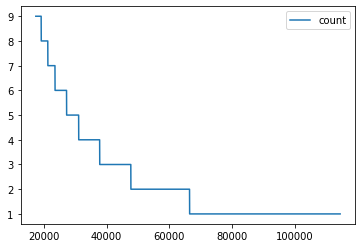

In [9]:
unique_body_tokens[unique_body_tokens['count'] < 10].plot()

In [10]:
unique_body_tokens[unique_body_tokens['count'] == 1].sample(10)

,token,count
98817,""" r[count++] = s.substring(i0, i1);""",1
108831,INPUT_ARGUMENTS,1
105527,"""Timeout waiting for task [""",1
85730,"""No negative maxExpansions allowed.""",1
69170,"""{\""index\"": {\""_index\"": \""geo-data\"", \""_id\...",1
113313,RestDeleteByQueryAction,1
106286,waitForPathToExist,1
82098,segmentMinDoc,1
103597,redirectToMlNode,1
111401,"""Number o = Short.valueOf((short)0); Float b =...",1


[Text(0, 0.5, 'Subtoken frequency'),
 Text(0.5, 0, 'Rank by frequency count'),
 Text(0.5, 1.0, 'Distribution of subtoken frequency')]

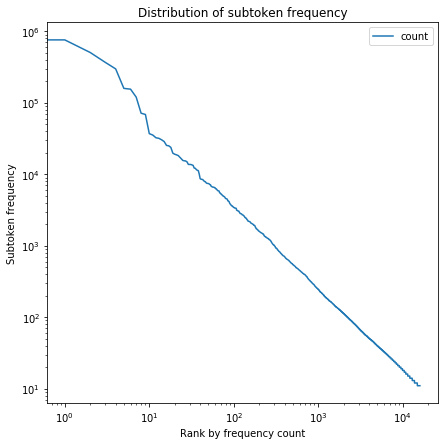

In [11]:
# index by position in the list which is sorted by frequency
ax = unique_body_tokens[unique_body_tokens['count'] > 10] \
    .plot(loglog=True, figsize=(7, 7))
ax.set(title='Distribution of subtoken frequency', xlabel='Rank by frequency count', ylabel='Subtoken frequency')

In [13]:
# # yes, the pandas groupby interface is THIS stupid :) ...
# unique_body_tokens = repeating_body_tokens \
#     .groupby(lambda index: repeating_body_tokens[index]).count()

# unique_body_tokens.head(30)

In [14]:
# define output vocabulary

repeating_method_subtokens = pd.Series(chain.from_iterable(df.method_name.progress_apply(get_subtokens).values))

# yes, the pandas groupby interface is THIS stupid :) ...
unique_method_subtokens = repeating_method_subtokens \
    .groupby(lambda index: repeating_method_subtokens[index]).count() \
    .sort_values(ascending=False)

unique_method_subtokens.head(30)

test        23812
get         14262
to           6460
set          4309
create       4088
with         3258
xcontent     3092
index        2840
field        2641
write        2493
instance     2477
name         2320
do           2317
is           2272
equals       2241
from         2230
hash         2171
code         2109
parse        2093
string       2021
query        1876
type         1747
and          1583
assert       1549
on           1520
random       1512
request      1504
value        1498
node         1418
add          1362
dtype: int64

[Text(0, 0.5, 'Subtoken frequency'),
 Text(0.5, 0, 'Rank by frequency count'),
 Text(0.5, 1.0, 'Distribution of subtoken frequency')]

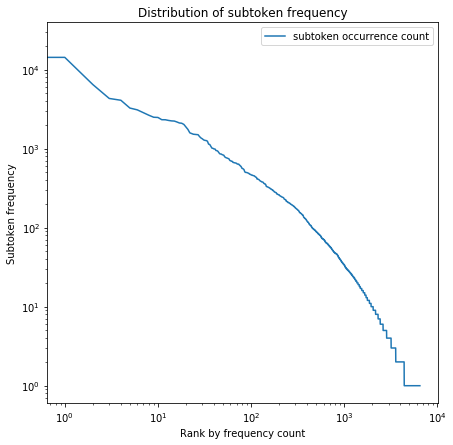

In [15]:
# index by position in the list which is sorted by frequency
ax = unique_method_subtokens \
    .sort_values(ascending=False).reset_index().rename(columns={0: 'subtoken occurrence count'}) \
    .plot(loglog=True, figsize=(7, 7))
ax.set(title='Distribution of subtoken frequency', xlabel='Rank by frequency count', ylabel='Subtoken frequency')

In [16]:
len(unique_method_subtokens)

6504

In [22]:
df_unique_method_name_subtokens = pd.DataFrame.from_dict(Counter(repeating_method_subtokens.values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

df_unique_method_name_subtokens.head(30)

,token,count
0,test,23812
1,get,14262
2,to,6460
3,set,4309
4,create,4088
5,with,3258
6,xcontent,3092
7,index,2840
8,field,2641
9,write,2493


In [30]:
df_unique_method_name_subtokens[df_unique_method_name_subtokens['count'] == 1].sample(10)

,token,count
4950,unzip,1
6413,rules_given,1
5762,completely,1
4418,lists2,1
4823,metadatas,1
5272,config_should,1
5148,rework,1
5218,orderby,1
5109,disappeared,1
5211,cos,1


In [60]:
# dataset

df['body_tokens'] = df['body'].progress_apply(tokenize_method_body)
df['method_name_subtokens'] = df['method_name'].progress_apply(get_subtokens)
df_clean = df[df.body_tokens.str.len() > 0] # remove invalid methods which cannot be parsed

df.head(5)

invalid_body_count = 37000
invalid_body_count = 38000
invalid_body_count = 39000
invalid_body_count = 40000
invalid_body_count = 41000
invalid_body_count = 42000
invalid_body_count = 43000
invalid_body_count = 44000
invalid_body_count = 45000
invalid_body_count = 46000
invalid_body_count = 47000
invalid_body_count = 48000



,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations,body_tokens,method_name_subtokens
0,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testInvalidBlockQuote,void,[],"{ String input = ""\""foo\"": \""\""\""bar\""""; expec...",None,['public'],[],"[{, String, input, =, ""\""foo\"": \""\""\""bar\"""", ...","[test, invalid, block, quote]"
1,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testSimpleBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort baz\"""", replac...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort baz\"""", ...","[test, simple, block, quote]"
2,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testMultipleBlockQuotes,void,[],"{ assertEquals( ""\""foo\"": \""bort baz\"", \""bar\...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort baz\"", \...","[test, multiple, block, quotes]"
3,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testEscapingInBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort\\\"" baz\"""", re...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort\\\"" baz\...","[test, escaping, in, block, quote]"
4,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testIsDocWriteRequest,void,[],{ assertTrue((boolean) RestTestsFromSnippetsTa...,None,['public'],[],"[{, assertTrue, (, (, boolean, ), RestTestsFro...","[test, is, doc, write, request]"


In [73]:
def get_vocabulary(series):
    all_repeating = pd.Series(chain.from_iterable(series.values))

    return pd.DataFrame.from_dict(Counter(all_repeating.values), orient='index') \
        .sort_values(by=0, ascending=False) \
        .reset_index().rename(columns={'index': 'token', 0: 'count'})

In [74]:
input_vocabulary = get_vocabulary(df_clean.body_tokens)
output_vocabulary = get_vocabulary(df_clean.method_name_subtokens)
len(input_vocabulary), len(output_vocabulary)

(114536, 5855)

In [79]:
df_train, df_test = train_test_split(df_clean, test_size=0.2)

len(df_train), len(df_test)

(70506, 17627)

In [80]:
df_train.body_tokens

16381            [{, return, mutate, (, original, ), ;, }]
14810    [{, return, new, TermQuery, (, new, Term, (, "...
15654    [{, assertAcked, (, prepareCreate, (, "test", ...
43676    [{, return, new, NodeRequest, (, request, ), ;...
44636     [{, return, visitor, ., visit, (, this, ), ;, }]
                               ...                        
99566    [{, final, Settings, ., Builder, clientSetting...
98642    [{, return, restHighLevelClient, ., performReq...
95612                       [{, return, memoryStats, ;, }]
42730    [{, Map, <, Class, <, ?, >, ,, XContentBuilder...
70697    [{, assertNull, (, new, StDistance, (, EMPTY, ...
Name: body_tokens, Length: 70506, dtype: object

In [81]:
df_train.method_name_subtokens

16381                                  [create, mutation]
14810                                         [to, query]
15654    [test, create, index, with, aliases, in, source]
43676                                [new, node, request]
44636                                             [visit]
                               ...                       
99566                           [create, blob, container]
98642                            [get, ssl, certificates]
95612                                [get, memory, stats]
42730      [get, xcontent, human, readable, transformers]
70697                              [test, null, handling]
Name: method_name_subtokens, Length: 70506, dtype: object

In [72]:
len(input_vocabulary[input_vocabulary['count'] > 10])

15959

In [17]:
# define model: input embedding > LSTM encoder > LSTM decoder > softmax

In [18]:
# TODO: use hyper parameters
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

In [82]:
# raw hyper parameters

# TODO: limit the input vocabulary size for now
input_vocab_size = 10000 # the number of method body tokens
output_vocab_size = len(output_vocabulary) # used for the softmax layer, like num_classes

input_embedding_dim = 50
latent_dim = 128 # encoder-decoder latent space dimensions

epochs = 10
batch_size=64

In [83]:
# TODO: input shape

model = tf.keras.Sequential([
    layers.Embedding(input_dim=input_vocab_size, output_dim=input_embedding_dim),
    layers.LSTM(latent_dim),
    layers.Dense(output_vocab_size, activation='softmax')
], name='Simple LSTM')

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

Model: "Simple LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 50)          500000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_8 (Dense)              (None, 5855)              755295    
Total params: 1,346,943
Trainable params: 1,346,943
Non-trainable params: 0
_________________________________________________________________


In [86]:
df_train.method_name_subtokens.shape

(70506,)

In [84]:
history = model.fit(
    df_train.body_tokens,
    df_train.method_name_subtokens,
    epochs=epochs,
    batch_size=batch_size
)

history

ValueError: You are passing a target array of shape (70506, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)

In [ ]:
prediction = class_names[np.argmax(model.predict(test_x[0]))]
prediction

In [34]:
encoder_input = layers.Input(shape=(None, ))
encoder_embedded = layers.Embedding(input_dim=input_vocab_size, output_dim=input_embedding_dim)(encoder_input)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(latent_dim, return_state=True, name='encoder')(encoder_embedded)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None, ))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(decoder_units, name='decoder')(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10, activation='softmax')(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 50)     500000      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 64)     128000      input_7[0][0]                    
____________________________________________________________________________________________